In [23]:
import numpy as np
import gymnasium as gym
import matplotlib.pyplot as plt

# Create the environment
def create_env():
    return gym.make('FrozenLake-v1', is_slippery=False)  # or True, depending on your use case

# Initialize Q-table
def initialize_q_table(env):
    number_of_states = env.observation_space.n #16, campo 4x4
    number_of_actions = env.action_space.n #4, su,giu,dx,sx
    return np.zeros((number_of_states, number_of_actions))

# Decay function for epsilon
def decay_function(episode, total_train_episodes, min_epsilon=0.01):
    return max(min_epsilon, min(1.0, 1.0 - np.log10((episode + 1) / (total_train_episodes * 0.1))))

# Choose action based on epsilon-greedy policy (Behavior Policy)
def choose_action(q_table, state, epsilon, env):
    if np.random.random() <= epsilon:
        return env.action_space.sample()  # Exploration
    else:
        return np.argmax(q_table[state])  # Exploitation

# Generate an episode
def generate_episode(epsilon, q_table, env, max_env_steps):
    state = env.reset()
    total_reward = 0
    done = False
    trajectory = []
    
    for step in range(max_env_steps):
        if isinstance(state, tuple):
            state = state[0]

        action = choose_action(q_table, state, epsilon, env)
        new_state, reward, done, info, _ = env.step(action)
        trajectory.append((state, action, reward))
        state = new_state
        total_reward += reward
        if done:
            break
    
    return trajectory, total_reward

# Off-Policy Monte Carlo with Importance Sampling
def every_visit_monte_carlo(env, total_train_episodes, gamma, max_epsilon, min_epsilon):
    q_table = initialize_q_table(env)
    c_table = np.zeros_like(q_table)  # C table for accumulating weights
    rewards = []
    
    max_env_steps = env.spec.max_episode_steps
    
    for episode in range(total_train_episodes):
        epsilon = decay_function(episode, total_train_episodes, min_epsilon)
        trajectory, total_reward = generate_episode(epsilon, q_table, env, max_env_steps)
        g = 0
        w = 1  # Initial weight
        
        for t in reversed(range(len(trajectory))):
            state, action, reward = trajectory[t]
            g = gamma * g + reward
            c_table[state, action] += w
            q_table[state, action] += (w / c_table[state, action]) * (g - q_table[state, action])
            
            # If the action taken is not the one that would have been taken by the greedy policy, break
            if action != np.argmax(q_table[state]):
                break
            
            w *= 1.0 / (epsilon / env.action_space.n)  # Update weight
        
        if episode % 100 == 0:
            rewards.append(total_reward)
            print(f"Episode {episode}, epsilon {epsilon:.4f}, reward {total_reward:.2f}")
    
    rewards.append(total_reward)
    print(f"Episode {episode}, epsilon {epsilon:.4f}, reward {total_reward:.2f}")
    return q_table, rewards


# First-Visit Monte Carlo with Off-Policy Control
def first_visit_monte_carlo(env, total_train_episodes, gamma, max_epsilon, min_epsilon):
    q_table = initialize_q_table(env)
    returns_count = np.zeros_like(q_table)  # Counter for returns
    rewards = []

    # Inizializza un array 3D per memorizzare i valori di ciascuna cella per ogni episodio
    history = np.zeros((total_train_episodes, *q_table.shape))

    max_env_steps = env.spec.max_episode_steps
    
    for episode in range(total_train_episodes):
        epsilon = decay_function(episode, total_train_episodes, min_epsilon)
        trajectory, total_reward = generate_episode(epsilon, q_table, env, max_env_steps)
        g = 0
        
        first_visit_check = set()  # Set to check first visit
        
        for t in reversed(range(len(trajectory))):
            state, action, reward = trajectory[t]
            g = gamma * g + reward
            
            # First visit check
            if (state, action) not in first_visit_check:
                first_visit_check.add((state, action))
                returns_count[state, action] += 1
                q_table[state, action] += (1 / returns_count[state, action]) * (g - q_table[state, action])
            
            # Se l'azione eseguita non è quella che sarebbe stata scelta dalla policy greedy, interrompi
            if action != np.argmax(q_table[state]):
                break

        # Memorizza lo stato della Q-table al termine dell'episodio
        history[episode] = q_table

        if episode % 100 == 0:
            rewards.append(total_reward)
            print(f"Episode {episode}, epsilon {epsilon:.4f}, reward {total_reward:.2f}")
    
    # Calcola la varianza per ciascuna cella attraverso tutte le iterazioni
    varianza_per_cella = np.var(history, axis=0)
    print(f"\nVarianza per ogni cella della Q-table:\n{varianza_per_cella}\n")
    plot_heatmap(varianza_per_cella)
    plot_matrix_colormap(varianza_per_cella)
    plot_bar_chart(varianza_per_cella)
    plot_surface(varianza_per_cella)

    rewards.append(total_reward)
    print(f"Episode {episode}, epsilon {epsilon:.4f}, reward {total_reward:.2f}")
    return q_table, rewards


# Plotting the training rewards
def plot_rewards(rewards, title, save_path):
    x = np.linspace(0, len(rewards) * 50, len(rewards))
    plt.plot(x, rewards, label='Monte Carlo')
    plt.title(title)
    plt.xlabel('Episodes')
    plt.ylabel('Reward')
    plt.legend()
    plt.savefig(save_path)
    plt.show()


    # Testing the policy with an epsilon-greedy approach
def test_policy_epsilon(env, q_table, num_episodes=10, epsilon=0.1):
    print(f"Testing the policy with epsilon = {epsilon}")
    rewards = []
    max_env_steps = env.spec.max_episode_steps
    
    for episode in range(num_episodes):
        state = env.reset()
        total_rewards = 0
        done = False
        
        for step in range(max_env_steps):
            if isinstance(state, tuple):
                state = state[0]
            
            # Use epsilon-greedy for testing
            if np.random.random() < epsilon:
                action = env.action_space.sample()  # Exploration
            else:
                action = np.argmax(q_table[state])  # Exploitation

            state, reward, done, info, _ = env.step(action)
            total_rewards += reward
            env.render()
            if done:
                env.render()
                break
        
        rewards.append(total_rewards)
        print(f"Episode {episode}, reward {total_rewards}")
    
    print(f"Average score: {np.mean(rewards)}")


In [24]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def plot_heatmap(varianza_per_cella):
    plt.figure(figsize=(10, 6))
    sns.heatmap(varianza_per_cella, annot=True, cmap="Reds", cbar=True, square=True)
    plt.title("Mappa di Calore della Varianza per Cella della Q-Table")
    plt.xlabel("Azioni (Sinistra, Giù, Destra, Su)")
    plt.ylabel("Stati")
    plt.show()

def plot_matrix_colormap(varianza_per_cella):
    plt.figure(figsize=(10, 6))
    plt.imshow(varianza_per_cella, cmap='Greys', interpolation='none')
    plt.colorbar(label='Varianza')
    plt.title("Varianza della Q-Table (16x4)")
    plt.xlabel("Azioni (Sinistra, Giù, Destra, Su)")
    plt.ylabel("Celle")
    plt.xticks(ticks=[0, 1, 2, 3], labels=['Sinistra', 'Giù', 'Destra', 'Su'])
    plt.yticks(ticks=np.arange(16), labels=[f"Cella {i+1}" for i in range(16)])
    plt.show()

def plot_bar_chart(varianza_per_cella):
    varianza_flat = varianza_per_cella.flatten()
    plt.figure(figsize=(14, 7))
    plt.bar(range(len(varianza_flat)), varianza_flat, color='blue')
    plt.title("Varianza per Stato-Azione nella Q-Table")
    plt.xlabel("Combinazioni Stato-Azione")
    plt.ylabel("Varianza")
    plt.show()

from mpl_toolkits.mplot3d import Axes3D

def plot_surface(varianza_per_cella):
    fig = plt.figure(figsize=(10, 6))
    ax = fig.add_subplot(111, projection='3d')
    X, Y = np.meshgrid(range(varianza_per_cella.shape[1]), range(varianza_per_cella.shape[0]))
    ax.plot_surface(X, Y, varianza_per_cella, cmap='viridis')
    ax.set_title("Superficie 3D della Varianza per Cella")
    ax.set_xlabel("Azioni")
    ax.set_ylabel("Stati")
    ax.set_zlabel("Varianza")
    plt.show()



 ********** Training number 0
Episode 0, epsilon 1.0000, reward 0.00
Episode 100, epsilon 0.9957, reward 0.00
Episode 200, epsilon 0.6968, reward 0.00
Episode 300, epsilon 0.5214, reward 0.00
Episode 400, epsilon 0.3969, reward 1.00
Episode 500, epsilon 0.3002, reward 1.00
Episode 600, epsilon 0.2211, reward 1.00
Episode 700, epsilon 0.1543, reward 1.00
Episode 800, epsilon 0.0964, reward 1.00
Episode 900, epsilon 0.0453, reward 1.00

Varianza per ogni cella della Q-table:
[[0.20568029 0.02677127 0.20851214 0.11913013]
 [0.17592169 0.         0.21275964 0.17572505]
 [0.08117372 0.1490583  0.05910147 0.17360273]
 [0.18187298 0.         0.         0.        ]
 [0.02874484 0.         0.         0.11731392]
 [0.         0.         0.         0.        ]
 [0.         0.22290054 0.         0.16973402]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]
 [0.         0.22742632 0.         0.23062404]
 [0.

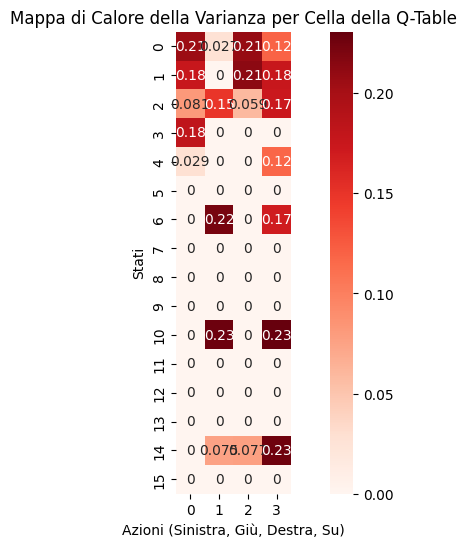

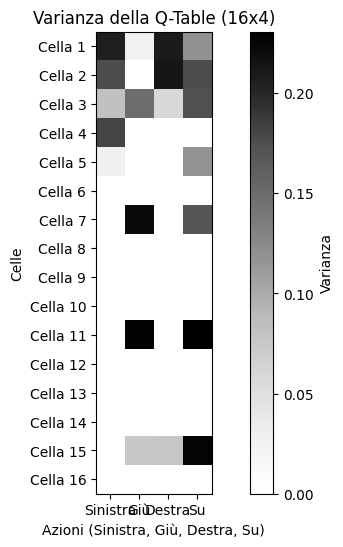

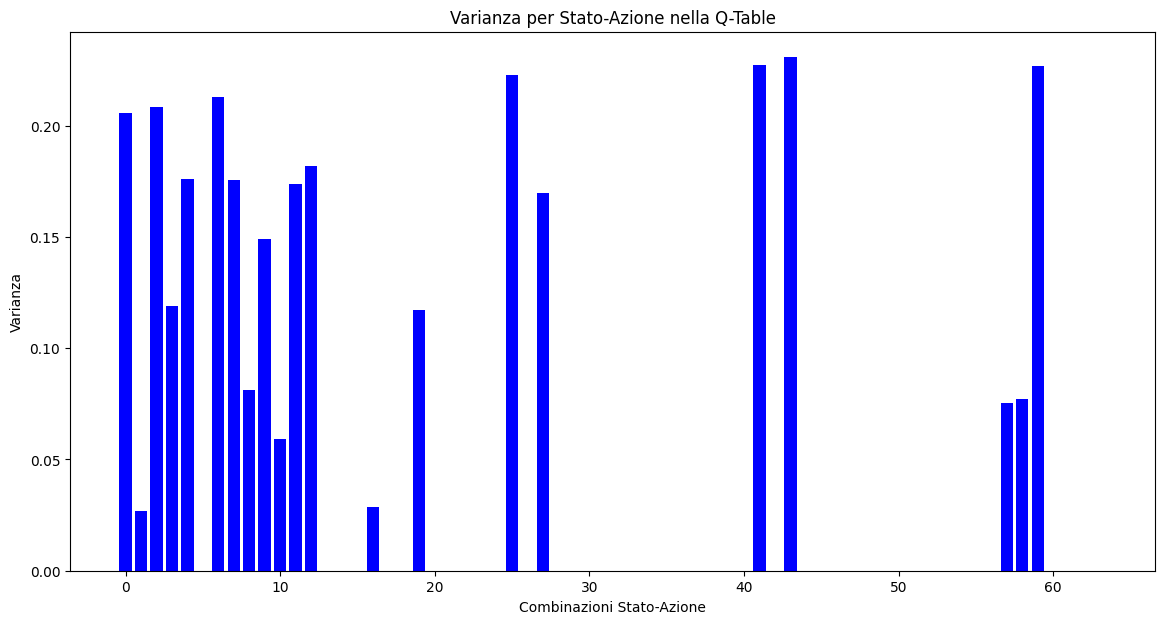

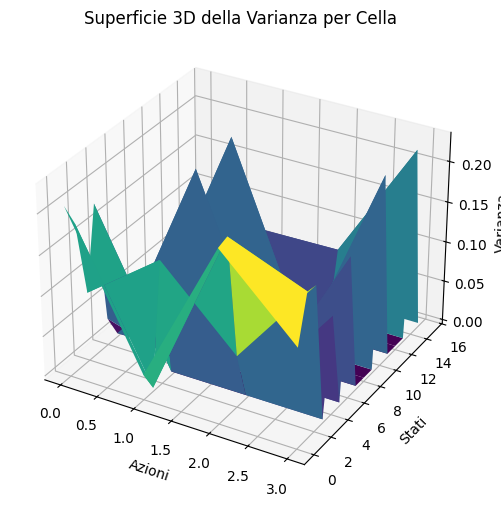

Episode 999, epsilon 0.0100, reward 1.00
Mean rewards:  [[0.94148015 0.46603267 0.95083295 0.94148015]
 [0.94148015 0.         0.96043906 0.95099005]
 [0.47549502 0.91181522 0.63399337 0.72044701]
 [0.96059601 0.         0.         0.        ]
 [0.46603267 0.         0.         0.94148015]
 [0.         0.         0.         0.        ]
 [0.         0.9801     0.         0.95422406]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]
 [0.         0.99       0.         0.970299  ]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]
 [0.         0.99       1.         0.9801    ]
 [0.         0.         0.         0.        ]]
Testing the policy with epsilon = 0.1
Episode 0, reward 1.0
Average score: 1.0


In [25]:
# Main code
if __name__ == "__main__":
    n_times = 1 #10 is is slippery true, 5 altrimenti
    total_train_episodes = 1000 #50000 if is slippery true
    gamma = 0.99
    max_epsilon = 1.0
    min_epsilon = 0.01

    env = create_env()

    MC_tables = []
    MC_rewards = []

    for number in range(n_times):
        print(f"\n ********** Training number {number}")
        q_table, rewards = first_visit_monte_carlo(env, total_train_episodes, gamma, max_epsilon, min_epsilon)
        MC_tables.append(q_table)
        MC_rewards.append(rewards)
        
    #Da non considerare mc mean rw    
    MC_mean = np.mean(np.array(MC_rewards), axis=0)
    MC_mean_tables = np.mean(np.array(MC_tables), axis=0)
    
    np.save('OFF/imgs/FV_MC_mean.npy', MC_mean)
    np.save('OFF/models/FV_MC_tables.npy', MC_mean_tables)
    #np.save('OFF/imgs/FV_MC_IS_mean.npy', MC_mean)
    #np.save('OFF/models/FV_MC_IS_tables.npy', MC_mean_tables)
    #EV
    #np.save('OFF/imgs/EV_MC_mean.npy', MC_mean)
    #np.save('OFF/models/EV_MC_tables.npy', MC_mean_tables)
    #np.save('OFF/imgs/EV_MC_IS_mean.npy', MC_mean)
    #np.save('OFF/models/EV_MC_IS_tables.npy', MC_mean_tables)
    print("Mean rewards: ", MC_mean_tables)

    # plot_rewards(MC_mean, "Off-Policy Monte Carlo FV", "OFF/imgs/FV_MC_mean.png")
    # plot_rewards(MC_mean, "Off-Policy Monte Carlo FV", "OFF/imgs/FV_MC_IS_mean.png")
    #plot_rewards(MC_mean, "Off-Policy Monte Carlo FV", "OFF/imgs/EV_MC_IS_mean.png")

    # Load Q-tables and test
    q_table = np.load('OFF/models/FV_MC_tables.npy', allow_pickle=True)
    #q_table = np.load('OFF/models/FV_MC_IS_tables.npy', allow_pickle=True)
    # q_table = np.load('OFF/models/EV_MC_tables.npy', allow_pickle=True)
    #q_table = np.load('OFF/models/EV_MC_IS_tables.npy', allow_pickle=True)
    
    env = gym.make('FrozenLake-v1', is_slippery=False, render_mode="human")
    
    test_policy_epsilon(env, q_table, num_episodes=1, epsilon=0.1)
    
    env.close()


In [14]:
# Main code
if __name__ == "__main__":
    # Caso is slippery=True -> 10, 5 a false
    n_times = 5
    # Caso is slippery=True -> 50000, 10000 a false
    total_train_episodes = 5000
    gamma = 0.99
    max_epsilon = 1.0
    min_epsilon = 0.01

    env = create_env()

    MC_tables = []
    MC_rewards = []

    for number in range(n_times):
        print(f"\n ********** Training number {number}")
        q_table, rewards = first_visit_monte_carlo(env, total_train_episodes, gamma, max_epsilon, min_epsilon)
        MC_tables.append(q_table)
        MC_rewards.append(rewards)

    MC_mean = np.mean(np.array(MC_rewards), axis=0)
    MC_mean_tables = np.mean(np.array(MC_tables), axis=0)
    #np.save('OFF/imgs/EV_MC_mean.npy', MC_mean)
    #np.save('OFF/models/EV_MC_tables.npy', MC_mean_tables) 
    #np.save('OFF/imgs/EV_MC_IS_mean.npy', MC_mean)
    #np.save('OFF/models/EV_MC_IS_tables.npy', MC_mean_tables)
    np.save('OFF/imgs/FV_MC_mean.npy', MC_mean)
    np.save('OFF/models/FV_MC_tables.npy', MC_mean_tables) 
    #np.save('OFF/imgs/FV_MC_IS_mean.npy', MC_mean)
    #np.save('OFF/models/FV_MC_IS_tables.npy', MC_mean_tables)
    print("Mean rewards: ", MC_mean_tables)

    #plot_rewards(MC_mean, "Off-Policy Monte Carlo EV", "OFF/imgs/EV_MC_mean.png") MISSING!!!!!!!!!!!!!!
    #plot_rewards(MC_mean, "Off-Policy Monte Carlo EV", "OFF/imgs/EV_MC_IS_mean.png")
    #plot_rewards(MC_mean, "Off-Policy Monte Carlo FV", "OFF/imgs/FV_MC_mean.png")
    #plot_rewards(MC_mean, "Off-Policy Monte Carlo FV", "OFF/imgs/FV_MC_IS_mean.png")

    # Load Q-tables and test
    #q_table = np.load('OFF/models/EV_MC_IS_tables.npy', allow_pickle=True)
    #q_table = np.load('OFF/models/EV_MC_tables.npy', allow_pickle=True)
    q_table = np.load('OFF/models/FV_MC_tables.npy', allow_pickle=True)
    #q_table = np.load('OFF/models/FV_MC_IS_tables.npy', allow_pickle=True)
    
    env = gym.make('FrozenLake-v1', is_slippery=False, render_mode="human")
    
    test_policy_epsilon(env, q_table, num_episodes=1, epsilon=0.1)
    
    env.close()



 ********** Training number 0
Episode 0, epsilon 1.0000, reward 0.00
Episode 100, epsilon 1.0000, reward 0.00
Episode 200, epsilon 1.0000, reward 0.00
Episode 300, epsilon 1.0000, reward 0.00
Episode 400, epsilon 1.0000, reward 0.00
Episode 500, epsilon 0.9991, reward 0.00
Episode 600, epsilon 0.9201, reward 0.00
Episode 700, epsilon 0.8533, reward 0.00
Episode 800, epsilon 0.7953, reward 1.00
Episode 900, epsilon 0.7442, reward 0.00
Episode 1000, epsilon 0.6985, reward 1.00
Episode 1100, epsilon 0.6572, reward 0.00
Episode 1200, epsilon 0.6194, reward 0.00
Episode 1300, epsilon 0.5847, reward 0.00
Episode 1400, epsilon 0.5525, reward 0.00
Episode 1500, epsilon 0.5226, reward 0.00
Episode 1600, epsilon 0.4946, reward 0.00
Episode 1700, epsilon 0.4683, reward 0.00
Episode 1800, epsilon 0.4435, reward 0.00
Episode 1900, epsilon 0.4200, reward 0.00
Episode 2000, epsilon 0.3977, reward 0.00
Episode 2100, epsilon 0.3765, reward 0.00
Episode 2200, epsilon 0.3563, reward 0.00
Episode 2300, e

# Policy Plot

In [ ]:

import numpy as np
import matplotlib.pyplot as plt

def plot_policy(q_table, grid_size=(4, 4), title='Policy', save_path=None):
    """
    Plots the policy learned by the Q-table on a grid using text labels for directions.

    Parameters:
        q_table (numpy.ndarray): The Q-table from which to derive the policy.
        grid_size (tuple): The size of the grid representing the environment (default is (4, 4)).
    """
    # Define direction labels
    direction_labels = {
        0: '←',  # left
        1: '↓',  # down
        2: '→',  # right
        3: '↑'   # up
    }

  
    policy = np.argmax(q_table, axis=1).reshape(grid_size)
    
    
    # Set up the grid
    fig, ax = plt.subplots()
    ax.set_xticks(np.arange(grid_size[1]))
    ax.set_yticks(np.arange(grid_size[0]))
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    
    # Create grid
    ax.grid(which='both', linestyle='-', linewidth=2)
    
    # Plot direction labels
    i=0
    j=0
    for i in range(grid_size[0]):
        for j in range(grid_size[1]):
            action = policy[i, j]
            direction = direction_labels[action]
            #print("Cella:",i,j, "Azione", action, "Direzione", direction)
            ax.text(j + 0.5, grid_size[0] - i - 0.5, direction,
                    ha='center', va='center', fontsize=12, color='black')

    # Set the aspect of the plot to equal
    ax.set_aspect('equal')
    ax.set_title(title)
    ax.set_xlim(0, grid_size[1])
    ax.set_ylim(0, grid_size[0])
    plt.savefig(save_path)
    plt.show()

"""
# Usage example:
if __name__ == "__main__":
    # Assuming you have already saved your Q-tables as 'MC_tables.npy'
    #FV_q_table = np.load('OFF/models/FV_MC_tables.npy', allow_pickle=True)
    #EV_q_table = np.load('OFF/models/EV_MC_tables.npy', allow_pickle=True)
    #Prima erano FV_policy e EV_policy, poi abbiamo cambiato in FV_IS e EV_IS
    #plot_policy(FV_q_table, title='FV Off Policy', save_path='OFF/imgs/FV_policy.png')
    #plot_policy(EV_q_table, title='EV Policy', save_path='OFF/imgs/EV_policy.png')
    #EV_q_table = np.load('OFF/models/EV_MC_IS_tables.npy', allow_pickle=True)
    #EV_q_table = np.load('OFF/models/EV_MC_IS_tables.npy', allow_pickle=True)    
    #plot_policy(EV_q_table, title='EV Off Policy', save_path='OFF/imgs/EV_MC_policy.png')
    #plot_policy(EV_q_table, title='EV Off Policy', save_path='OFF/imgs/EV_MC_IS_policy.png')
    
    #FV_q_table = np.load('OFF/models/FV_MC_tables.npy', allow_pickle=True)
    FV_q_table = np.load('OFF/models/FV_MC_IS_tables.npy', allow_pickle=True)    
    plot_policy(FV_q_table, title='FV Off Policy', save_path='OFF/imgs/FV_MC_IS_policy.png')
    #plot_policy(FV_q_table, title='FV Off Policy', save_path='OFF/imgs/FV_MC_policy.png')
    """


# Codice corretto

In [104]:
import numpy as np
import gymnasium as gym
import matplotlib.pyplot as plt

# Create the environment
def create_env():
    return gym.make('FrozenLake-v1', is_slippery=False)  # or True, depending on your use case

# Initialize Q-table
def initialize_q_table(env):
    number_of_states = env.observation_space.n #16, campo 4x4
    number_of_actions = env.action_space.n #4, su,giu,dx,sx
    return np.zeros((number_of_states, number_of_actions))

# Decay function for epsilon
def decay_function(episode, total_train_episodes, min_epsilon=0.01):
    return max(min_epsilon, min(1.0, 1.0 - np.log10((episode + 1) / (total_train_episodes * 0.1))))

# Choose action based on epsilon-greedy policy (Behavior Policy)
def choose_action(q_table, state, epsilon, env):
    if np.random.random() <= epsilon:
        return env.action_space.sample()  # Exploration
    else:
        return np.argmax(q_table[state])  # Exploitation

# Generate an episode
def generate_episode(epsilon, q_table, env, max_env_steps):
    state = env.reset()
    total_reward = 0
    done = False
    trajectory = []
    
    for step in range(max_env_steps):
        if isinstance(state, tuple):
            state = state[0]

        action = choose_action(q_table, state, epsilon, env)
        new_state, reward, done, info, _ = env.step(action)
        trajectory.append((state, action, reward))
        state = new_state
        total_reward += reward
        if done:
            break
    
    return trajectory, total_reward

# Off-Policy Monte Carlo with Importance Sampling

def every_visit_monte_carlo(env, total_train_episodes, gamma, max_epsilon, min_epsilon):
    q_table = initialize_q_table(env)
    c_table = np.zeros_like(q_table)  # C table for accumulating weights
    rewards = []
    success_counter = 0
    differences = []
    
    max_env_steps = env.spec.max_episode_steps
    stop = False
    
    for episode in range(total_train_episodes):
        if not stop:
            epsilon = decay_function(episode, total_train_episodes, min_epsilon)
            trajectory, total_reward = generate_episode(epsilon, q_table, env, max_env_steps)
            g = 0
            w = 1  # Initial weight
            
            for t in reversed(range(len(trajectory))):
                state, action, reward = trajectory[t]
                if reward==1:
                    success_counter +=1
                g = gamma * g + reward
                c_table[state, action] += w
                q_table[state, action] += (w / c_table[state, action]) * (g - q_table[state, action])
                differences.append(q_table[9,1])
                
                # If the action taken is not the one that would have been taken by the greedy policy, break
                if action != np.argmax(q_table[state]):
                    break
                
                w *= 1.0 / (epsilon / env.action_space.n)  # Update weight
            
            if episode % 50 == 0:
                rewards.append(total_reward)
                print(f"Episode {episode}, epsilon {epsilon:.4f}, reward {total_reward:.2f}")
            if success_counter == 10:
                print(f"\n***** Convergence reached at episode {episode} *****\n")
                with open('PROVE/convergence_log.txt', 'a') as file:
                    file.write(f"Ex number: {number}: Convergence: {episode} Epsilon: {epsilon}\n")
                stop = True
            if episode==total_train_episodes-1:
                with open('PROVE/convergence_log.txt', 'a') as file:
                    file.write(f"Ex number: {number} Convergence: NO\n")
    
    #rewards.append(total_reward)
    print(f"Episode {episode}, epsilon {epsilon:.4f}, reward {total_reward:.2f}")
    return q_table, rewards, differences


# First-Visit Monte Carlo with Off-Policy Control
def first_visit_monte_carlo(env, total_train_episodes, gamma, max_epsilon, min_epsilon):
    q_table = initialize_q_table(env)
    returns_count = np.zeros_like(q_table)  # Counter for returns
    rewards = []
    success_counter=0
    stop = False
    differences = []

    max_env_steps = env.spec.max_episode_steps
    
    for episode in range(total_train_episodes):
        if not stop:
            epsilon = decay_function(episode, total_train_episodes, min_epsilon)
            trajectory, total_reward = generate_episode(epsilon, q_table, env, max_env_steps)
            g = 0
            
            first_visit_check = set()  # Set to check first visit
            
            for t in reversed(range(len(trajectory))):
                state, action, reward = trajectory[t]
                if reward==1:
                    success_counter +=1
                g = gamma * g + reward
                
                # First visit check
                if (state, action) not in first_visit_check:
                    first_visit_check.add((state, action))
                    returns_count[state, action] += 1
                    q_table[state, action] += (1 / returns_count[state, action]) * (g - q_table[state, action])
                    differences.append(q_table[0,1])
                
                # Se l'azione eseguita non è quella che sarebbe stata scelta dalla policy greedy, interrompi
                if action != np.argmax(q_table[state]):
                    break
            
            if episode % 50 == 0:
                rewards.append(total_reward)
                print(f"Episode {episode}, epsilon {epsilon:.4f}, reward {total_reward:.2f}")
            if success_counter == 10:
                print(f"\n***** Convergence reached at episode {episode} *****\n")
                with open('final/off/first_visit/convergence_log.txt', 'a') as file:
                    file.write(f"Ex number: {number}: Convergence: {episode} Epsilon: {epsilon}\n")
                stop = True
            if episode==total_train_episodes-1:
                with open('final/off/first_visit/convergence_log.txt', 'a') as file:
                    file.write(f"Ex number: {number} Convergence: NO\n")
    
    #print(f"\nVarianza per ogni cella della Q-table:\n{varianza_per_cella}\n")
    #rewards.append(total_reward)
    print(f"Episode {episode}, epsilon {epsilon:.4f}, reward {total_reward:.2f}")
    #plot_heatmap(varianza_per_cella)
    #plot_matrix_colormap(varianza_per_cella)
    #plot_bar_chart(varianza_per_cella)
    #plot_surface(varianza_per_cella)
    return q_table, rewards, differences



# Plotting the training rewards
def plot_rewards(rewards, title, save_path):
    x = np.linspace(0, len(rewards) * 50, len(rewards))
    plt.plot(x, rewards, label='Monte Carlo')
    plt.title(title)
    plt.xlabel('Episodes')
    plt.ylabel('Reward')
    plt.legend()
    plt.savefig(save_path)
    plt.show()


    # Testing the policy with an epsilon-greedy approach
def test_policy_epsilon(env, q_table, num_episodes=10, epsilon=0.1):
    print(f"Testing the policy with epsilon = {epsilon}")
    rewards = []
    max_env_steps = env.spec.max_episode_steps
    
    for episode in range(num_episodes):
        state = env.reset()
        total_rewards = 0
        done = False
        
        for step in range(max_env_steps):
            if isinstance(state, tuple):
                state = state[0]
            
            # Use epsilon-greedy for testing
            if np.random.random() < epsilon:
                action = env.action_space.sample()  # Exploration
            else:
                action = np.argmax(q_table[state])  # Exploitation

            state, reward, done, info, _ = env.step(action)
            total_rewards += reward
            env.render()
            if done:
                env.render()
                break
        
        rewards.append(total_rewards)
        print(f"Episode {episode}, reward {total_rewards}")
    
    print(f"Average score: {np.mean(rewards)}")


In [105]:
# Main code
if __name__ == "__main__":
    n_times = 100 #10 is is slippery true, 5 altrimenti
    total_train_episodes = 1000 #50000 if is slippery true
    gamma = 0.99
    max_epsilon = 1.0
    min_epsilon = 0.01

    env = create_env()

    MC_tables = []
    MC_rewards = []
    
    variances = []

    for number in range(1):
        print(f"\n ********** Training number {number}")
        #q_table, rewards = first_visit_monte_carlo(env, total_train_episodes, gamma, max_epsilon, min_epsilon)
        # q_table, rewards = every_visit_monte_carlo(env, total_train_episodes, gamma, max_epsilon, min_epsilon)
        # q_table, rewards, differences = first_visit_monte_carlo(env, total_train_episodes, gamma, max_epsilon, min_epsilon)
        q_table, rewards, differences = every_visit_monte_carlo(env, total_train_episodes, gamma, max_epsilon, min_epsilon)
        # q_table, rewards = Monte_Carlo(env, total_train_episodes, gamma, max_epsilon, min_epsilon,True)
        #print(f"\n\n*** DIFFERENCES ***\n\n + {differences}")
        MC_tables.append(q_table)
        MC_rewards.append(rewards)
        
    print(f"\n\n DIFFERENCE \n\n {differences}")
    
    # we perform the mean of the rewards and the Q-tables to reduce variance
    #MC_mean = np.mean(np.array(MC_rewards), axis=0)
    MC_mean_table = np.mean(np.array(MC_tables), axis=0)
    #save_path_rw = 'final/off/every_visit/imgs/results_MC_OFF_TAB_rw.png'  # Adding .npy to this path
    #save_path_mc = 'final/off/every_visit/models/table_MC_OFF_TAB.npy'
    save_path_rw = 'final/off/first_visit/imgs/results_MC_OFF_TAB_rw.png'  # Adding .npy to this path
    save_path_mc = 'final/off/first_visit/models/table_MC_OFF_TAB.npy'
    #np.save(save_path_rw, MC_mean)  # Save the mean rewards
    np.save(save_path_mc, MC_mean_table)  # Save the mean Q-table
    
    env = gym.make('FrozenLake-v1', is_slippery=False, render_mode="human")
    q_table = np.load(save_path_mc, allow_pickle=True)
    test_policy_epsilon(env, q_table, num_episodes=1, epsilon=0.1)
    
    env.close()
 


 ********** Training number 0
Episode 0, epsilon 1.0000, reward 0.00
Episode 50, epsilon 1.0000, reward 0.00
Episode 100, epsilon 0.9957, reward 0.00
Episode 150, epsilon 0.8210, reward 0.00
Episode 200, epsilon 0.6968, reward 1.00

***** Convergence reached at episode 201 *****

Episode 999, epsilon 0.6946, reward 1.00


 DIFFERENCE 

 [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,

In [103]:
 def analyze_convergence_data(filename):
    with open(filename, 'r') as file:
        lines = file.readlines()

    count_no_convergence = 0
    episodes = []
    epsilons = []

    for line in lines:
        if "Convergence: NO" in line:
            count_no_convergence += 1
        else:
            parts = line.split()
            try:
                # Trovare il numero di episodi
                convergence_index = parts.index('Convergence:') + 1
                episodes.append(int(parts[convergence_index]))

                # Trovare il valore di epsilon
                epsilon_index = parts.index('Epsilon:') + 1
                epsilons.append(float(parts[epsilon_index]))
            except ValueError:
                continue  # salta eventuali linee mal formattate

    total_convergence = len(lines) - count_no_convergence
    average_episodes = sum(episodes) / len(episodes) if episodes else 0
    average_epsilon = sum(epsilons) / len(epsilons) if epsilons else 0

    return {
        'Numero di volte in cui la convergenza è stata raggiunta': total_convergence,
        'Numero medio di episodi richiesti': average_episodes,
        'Valore medio di epsilon': average_epsilon
    }

# Nome del file da leggere
filename = 'final/off/every_visit/convergence_log.txt'
results = analyze_convergence_data(filename)
print("Numero di volte in cui la convergenza è stata raggiunta:", results['Numero di volte in cui la convergenza è stata raggiunta'])
print("Numero medio di episodi richiesti:", results['Numero medio di episodi richiesti'])
print("Valore medio di epsilon:", results['Valore medio di epsilon'])


Numero di volte in cui la convergenza è stata raggiunta: 32
Numero medio di episodi richiesti: 85.34375
Valore medio di epsilon: 0.3788337870644494


In [6]:
filename = 'final/off/first_visit/convergence_log.txt'
results = analyze_convergence_data(filename)
print("Numero di volte in cui la convergenza è stata raggiunta:", results['Numero di volte in cui la convergenza è stata raggiunta'])
print("Numero medio di episodi richiesti:", results['Numero medio di episodi richiesti'])
print("Valore medio di epsilon:", results['Valore medio di epsilon'])

Numero di volte in cui la convergenza è stata raggiunta: 36
Numero medio di episodi richiesti: 84.52777777777777
Valore medio di epsilon: 0.3839100023471462


In [7]:
filename = 'final/on/every_visit/convergence_log.txt'
results = analyze_convergence_data(filename)
print("Numero di volte in cui la convergenza è stata raggiunta:", results['Numero di volte in cui la convergenza è stata raggiunta'])
print("Numero medio di episodi richiesti:", results['Numero medio di episodi richiesti'])
print("Valore medio di epsilon:", results['Valore medio di epsilon'])

Numero di volte in cui la convergenza è stata raggiunta: 36
Numero medio di episodi richiesti: 82.36111111111111
Valore medio di epsilon: 0.39033331738961047


In [8]:
filename = 'final/on/first_visit/convergence_log.txt'
results = analyze_convergence_data(filename)
print("Numero di volte in cui la convergenza è stata raggiunta:", results['Numero di volte in cui la convergenza è stata raggiunta'])
print("Numero medio di episodi richiesti:", results['Numero medio di episodi richiesti'])
print("Valore medio di epsilon:", results['Valore medio di epsilon'])

Numero di volte in cui la convergenza è stata raggiunta: 40
Numero medio di episodi richiesti: 73.3
Valore medio di epsilon: 0.43652234009586677
